In [11]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

def load_match_events(events_dir: Path, match_id: int) -> list:
    path = events_dir / f"{match_id}.json"
    if not path.exists():
        raise FileNotFoundError(f"Missing events file: {path}")
    return json.loads(path.read_text(encoding="utf-8"))

def shots_df_from_events(events: list) -> pd.DataFrame:
    rows = []
    for ev in events:
        if ev.get("type", {}).get("name") != "Shot":
            continue

        loc = ev.get("location", None)
        if not loc or len(loc) != 2:
            continue

        team = (ev.get("team") or {}).get("name", None)
        period = ev.get("period", None)
        minute = ev.get("minute", None)
        second = ev.get("second", None)

        shot = ev.get("shot", {}) or {}
        outcome = (shot.get("outcome") or {}).get("name", None)
        xg = shot.get("statsbomb_xg", np.nan)

        end_loc = shot.get("end_location", None)  # can be [x,y,z]
        end_x = end_y = np.nan
        if isinstance(end_loc, list) and len(end_loc) >= 2:
            end_x, end_y = end_loc[0], end_loc[1]

        rows.append({
            "x": float(loc[0]),
            "y": float(loc[1]),
            "end_x": float(end_x) if end_x == end_x else np.nan,
            "end_y": float(end_y) if end_y == end_y else np.nan,
            "team": team,
            "period": period,
            "minute": minute,
            "second": second,
            "outcome": outcome,
            "xg": xg,
        })

    return pd.DataFrame(rows)

def mirror_xy(x, y):
    return 120.0 - x, 80.0 - y

def plot_match_shots(match_id: int, matches_360: pd.DataFrame, events_dir: Path,
                     home_color="red", away_color="blue",
                     flip_away_to_ltr=True, show_legend=True):
    # meta (home/away team names)
    mrow = matches_360.loc[matches_360["match_id"] == match_id]
    if mrow.empty:
        raise ValueError(f"match_id {match_id} not found in matches_360")
    home_team = mrow.iloc[0]["home_team"]
    away_team = mrow.iloc[0]["away_team"]

    events = load_match_events(events_dir, match_id)
    shots = shots_df_from_events(events)

    if shots.empty:
        print(f"No shots found for match_id={match_id}")
        return

    # OPTIONAL: flip away team shots so both teams attack left->right
    if flip_away_to_ltr:
        away_mask = shots["team"].eq(away_team)
        shots.loc[away_mask, ["x", "y"]] = shots.loc[away_mask].apply(
            lambda r: pd.Series(mirror_xy(r["x"], r["y"])), axis=1
        )

    # Plot
    pitch = Pitch(pitch_type="statsbomb")
    fig, ax = pitch.draw(figsize=(12, 8))

    home_shots = shots[shots["team"] == home_team]
    away_shots = shots[shots["team"] == away_team]

    pitch.scatter(home_shots["x"], home_shots["y"], ax=ax,
                  c=home_color, s=80, edgecolors="black", linewidth=0.5, alpha=0.85,
                  label=home_team)
    pitch.scatter(away_shots["x"], away_shots["y"], ax=ax,
                  c=away_color, s=80, edgecolors="black", linewidth=0.5, alpha=0.85,
                  label=away_team)

    ax.set_title(f"Shots — {home_team} vs {away_team} (match_id={match_id})", fontsize=14)

    if show_legend:
        ax.legend(loc="upper left", frameon=True)

    plt.show()
    return shots

# Example usage:
# match_id = 1234567
# shots = plot_match_shots(match_id, matches_360, events_dir, home_color="red", away_color="blue")


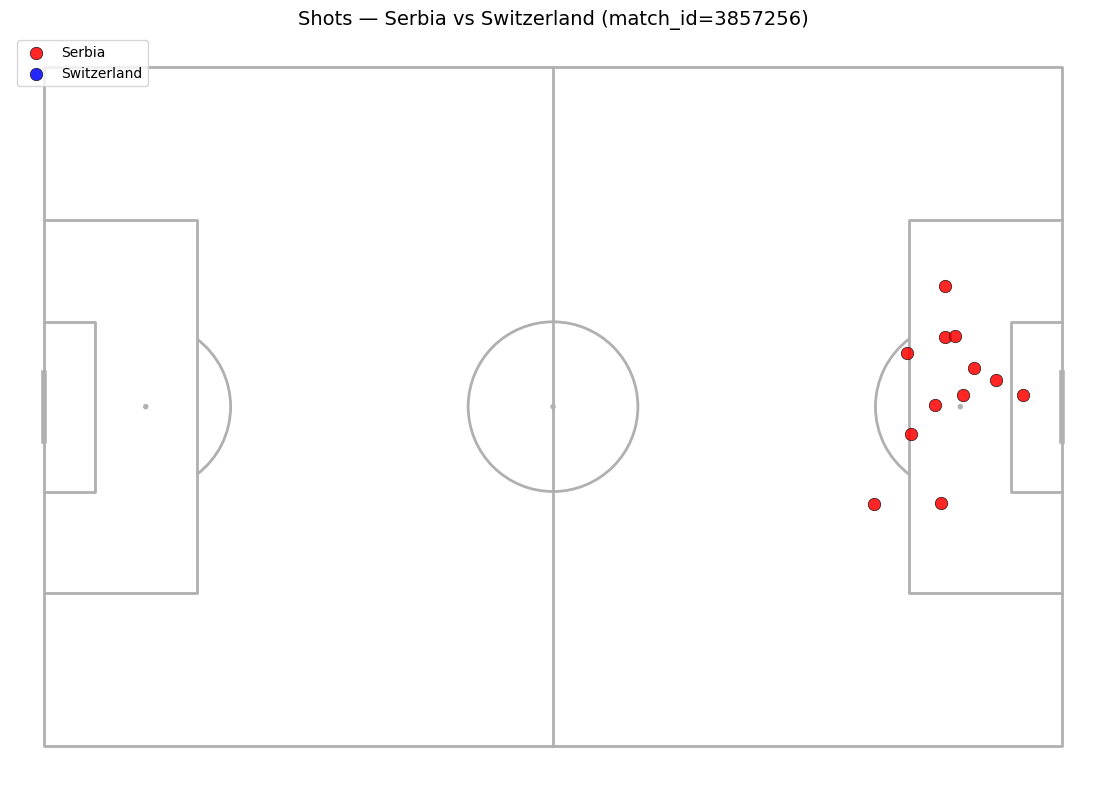

,x,y,end_x,end_y,team,period,minute,second,outcome,xg
0,NaN,NaN,108.2,38.5,Switzerland,1,0,18,Blocked,0.036566
1,NaN,NaN,114.8,40.6,Switzerland,1,0,22,Saved,0.353289
2,NaN,NaN,115.5,39.1,Switzerland,1,0,23,Saved,0.069527
3,112.2,36.8,120.0,35.3,Serbia,1,4,35,Off T,0.081609
4,97.8,51.5,120.0,36.1,Serbia,1,10,5,Post,0.030002


In [ ]:
match_id = 3857256
shots = plot_match_shots(
    match_id=match_id,
    matches_360=matches_360,
    events_dir=events_dir,
    home_color="red",
    away_color="blue",
    flip_away_to_ltr=False,   # set False if you want “true” attack directions
    show_legend=True
)
shots.head()
